### Compute Gallgar's Random Coding Exponent

In [1]:
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
#from pynverse import inversefunc


def kl_divergence(p, q):
    """
    Compute the Kullback-Leibler divergence between two probability mass vectors.

    Parameters:
    - p: numpy array representing the first probability mass function
    - q: numpy array representing the second probability mass function

    Returns:
    - kl_div: Kullback-Leibler divergence between p and q
    """
    # Ensure that the vectors have the same length
    assert len(p) == len(q), "Probability vectors must have the same length."

    # Avoid division by zero by adding a small constant to the vectors
    epsilon = 1e-20
    p = np.maximum(p, epsilon)
    q = np.maximum(q, epsilon)

    # Compute the KL divergence
    kl_div = np.sum(p * np.log2(p / q))

    return kl_div

def binary_entropy(p):
    """
    Compute binary entropy for a given probability.

    Parameters:
    - p: Probability (between 0 and 1)

    Returns:
    - entropy: Binary entropy for the given probability
    """
    if p == 0 or p == 1:
        return 0  # Entropy is 0 for perfectly certain events

    entropy = -p * np.log2(p) - (1 - p) * np.log2(1 - p)
    return entropy

def dev_binary_entropy(p):
    return -np.log2(p) + np.log2(1-p)

def binary_kl_divergence_single(p, q):
    """
    Compute binary KL divergence between two probabilities P and Q.
    """
    return p * np.log2(p / q) + (1 - p) * np.log2((1 - p) / (1 - q))



def inverse_binary_entropy_function(x, tolerance=1e-4, max_iterations=1e7):
    y = 0.2
    iter = 0
    while (np.abs(binary_entropy(y) - x) > tolerance) and iter < max_iterations:
        y = y - 0.2*(binary_entropy(y) - x) / dev_binary_entropy(y)
        iter += 1
    if np.abs(binary_entropy(y) - x) <= tolerance:
        return y
    else:
        return y
        #raise ValueError("Newton-Raphson method did not converge")


    # equation = lambda p: binary_entropy(p)
    # # Initial guess for fsolve
    # initial_guess = 0.2
    # result = fsolve(equation, initial_guess, xtol=1e-12)
    # return result[0] if 0 <= result[0] <= 1 else np.nan
    # # cube = (lambda p: binary_entropy(p))
    # # return inversefunc(cube, y_values=x)

def exponent_compute(r, epsilon):
    """
    Parameters:
    -       r: coding rate
    - epsilon: crossover probability

    Returns:
    -     E_r: random coding exponent
    """
    capacity          = 1 - binary_entropy(epsilon)
    epsilon_critical  = np.sqrt(epsilon) / (np.sqrt(epsilon) + np.sqrt(1-epsilon))
    capacity_critical = 1 - binary_entropy(epsilon_critical)
    if r >= capacity:
        E_r = 0
    elif r <= capacity_critical:
        E_r = 1 - np.log2(1 + 2*np.sqrt(epsilon * (1-epsilon))) - r
    elif (r <= capacity) and (r >= capacity_critical):
        epsilon_ref = inverse_binary_entropy_function(1-r)
        E_r = kl_divergence(np.array([epsilon_ref, 1-epsilon_ref]), 
                            np.array([epsilon, 1-epsilon]))
        #E_r = binary_kl_divergence_single(epsilon_ref, epsilon)
        #epsilon_ref = 0.5 - 0.5 * np.sqrt(1 - )
    # print(capacity_critical)
    # print(capacity)
    return E_r

r_values   = np.linspace(0, 1, 1000)
E_r_values = [exponent_compute(x, 0.05) for x in r_values]

#print(E_r_values)
# Plot the results
plt.plot(r_values, E_r_values, label='Random Coding Exponent')
plt.xlabel('x')
plt.ylabel('Exponent')
#plt.title('Inverse Binary Entropy Function')
plt.legend()
plt.show()




<Figure size 640x480 with 1 Axes>

0.2780719051126377
20
40
60


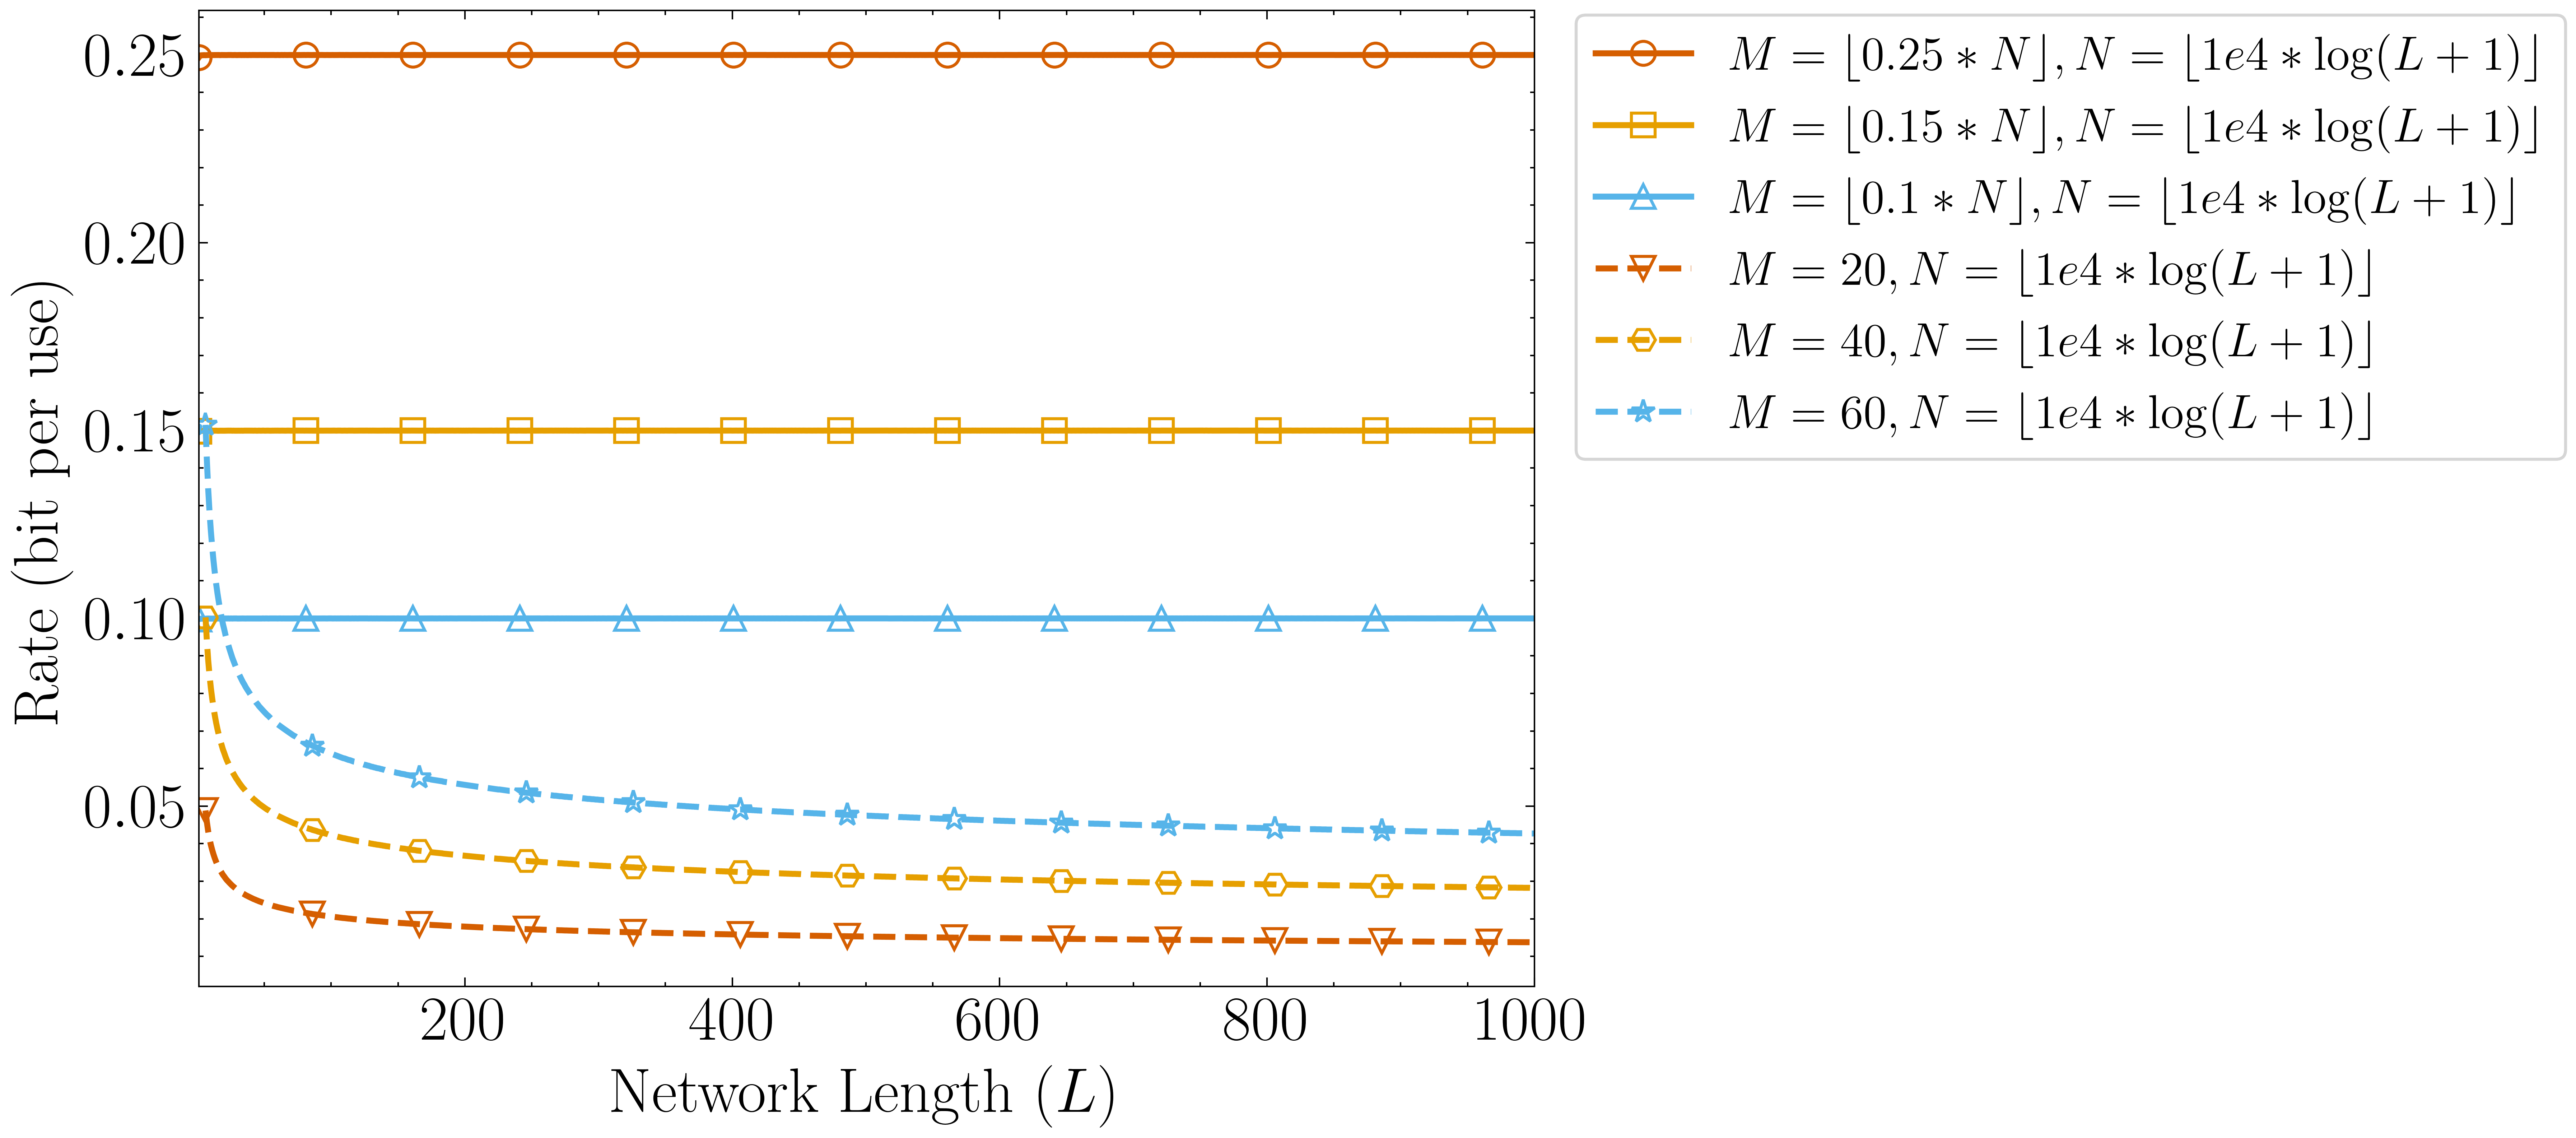

In [2]:
epsilon = 0.2
capacity          = 1 - binary_entropy(epsilon)
print(capacity)

parameter_hist = [[0.25,1e4], [0.15, 1e4], [0.1, 1e4]]

rate_hist = []
L_hist = np.arange(1, 1001)

for idx in range(len(parameter_hist)):
    M_N_ratio, N_L_ratio = parameter_hist[idx][0], parameter_hist[idx][1]

    for L in L_hist:
        N = np.floor(N_L_ratio * np.log(1+L))
        M = np.floor(N * M_N_ratio)
        M = np.maximum(M, 1)
        
        e2e_error = 1 - np.exp(-N * exponent_compute(M/N, epsilon))
        e2e_error = e2e_error ** L
        if e2e_error > 2**(-M):
            rate_NL = M/N * e2e_error - 1/N
        else:
            rate_NL = 0

        rate_hist.append(rate_NL)

rate_hist = np.array(rate_hist).reshape([len(parameter_hist), len(L_hist)])


parameter_hist_new = [[20,2e2], [40, 2e2], [60, 2e2]]
rate_hist_new = []
L_hist = np.arange(1, 1001)

for idx in range(len(parameter_hist_new)):
    M, N_L_ratio = parameter_hist_new[idx][0], parameter_hist_new[idx][1]
    print(M)
    for L in L_hist:
        N = np.floor(N_L_ratio * np.log(1+L))
        # M = np.floor(N * M_N_ratio)
        # M = np.maximum(M, 1)
        
        e2e_error = 1 - np.exp(-N * exponent_compute(M/N, epsilon))
        e2e_error = e2e_error ** L
        if e2e_error > 2**(-M):
            #print(M*e2e_error - 1)
            #print(e2e_error)
            rate_NL = M/N * e2e_error - 1/N
        else:
            rate_NL = 0

        rate_hist_new.append(rate_NL)

rate_hist_new = np.array(rate_hist_new).reshape([len(parameter_hist_new), len(L_hist)])









plt.style.use(['science','ieee'])
plt.rcParams['grid.color'] = 'gray'  # Grid color
plt.rcParams['grid.linestyle'] = '--'  # Grid line style
plt.rcParams['grid.linewidth'] = 0.5  # Grid line width
plt.rcParams['legend.frameon'] = True  # Show the legend border

#L = np.arange(1, 1001)
plt.figure(figsize=(8, 6))
ax = plt.gca()

# Plot the data
# ax.plot(L_hist, capacity*np.ones(1000), color="#0072B2", linestyle=':', label=r'Min-cut Capacity', linewidth=2,
#                                         marker='x', markersize=8, markevery=80, markerfacecolor='none')

ax.plot(L_hist, rate_hist[0,:], color="#D55E00", linestyle='solid', label=r'$M=\lfloor 0.25*N \rfloor, N=\lfloor 1e4*\log(L+1) \rfloor$', linewidth=2,
                                marker='o', markersize=8, markevery=80, markerfacecolor='none')
ax.plot(L_hist, rate_hist[1,:], color="#E69F00", linestyle='solid', label=r'$M=\lfloor 0.15*N \rfloor, N=\lfloor 1e4*\log(L+1) \rfloor$', linewidth=2,
                                marker='s', markersize=8, markevery=80, markerfacecolor='none')
ax.plot(L_hist, rate_hist[2,:], color="#56B4E9", linestyle='solid', label=r'$M=\lfloor 0.1*N \rfloor, N=\lfloor 1e4*\log(L+1) \rfloor$', linewidth=2,
                                marker='^', markersize=8, markevery=80, markerfacecolor='none')

ax.plot(L_hist[5:], rate_hist_new[0,5:], color="#D55E00", linestyle='--', label=r'$M=20, N=\lfloor 1e4*\log(L+1) \rfloor$', linewidth=2,
                                         marker='v', markersize=8, markevery=80, markerfacecolor='none')
ax.plot(L_hist[5:], rate_hist_new[1,5:], color="#E69F00", linestyle='--', label=r'$M=40, N=\lfloor 1e4*\log(L+1) \rfloor$', linewidth=2,
                                         marker='H', markersize=8, markevery=80, markerfacecolor='none')
ax.plot(L_hist[5:], rate_hist_new[2,5:], color='#56B4E9', linestyle='--', label=r'$M=60, N=\lfloor 1e4*\log(L+1) \rfloor$', linewidth=2,
                                         marker='*', markersize=8, markevery=80, markerfacecolor='none')

#print(rate_hist_new)


# Set axis labels and title
ax.set_xlabel('Network Length ($L$)',fontsize=21)
ax.set_ylabel('Rate (bit per use)',fontsize=21)

# Set x-axis limits
ax.set_xlim(1, 1000)

# Show legend
#ax.legend(loc='best', fontsize=12)
#ax.legend(loc='upper right', bbox_to_anchor=(1.52, 1.02), fontsize=16)
ax.legend(loc='upper right', bbox_to_anchor=(1.79, 1.02), fontsize=16)

# Show the grid
ax.grid(False, which='both')
ax.tick_params(axis='both', labelsize=21)
plt.savefig('figa_revision_BSC_Ga.pdf', bbox_inches='tight')
